In [48]:
import numpy as np
import pandas as pd
from sklearn.externals import joblib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [18, 10]

## Getting model and data

In [49]:
model = joblib.load('finalized_model.sav')
data = pd.read_csv('data.csv')

In [50]:
data.drop(['Unnamed: 0', 'married'], axis=1, inplace=True)
data.head()

,pphhsize,relate_duration,friends_connect,otherdate
0,4.0,21.916666,1,1
1,5.0,11.083333,1,1
2,4.0,33.750000,1,1
3,2.0,35.083332,1,1
4,2.0,50.500000,0,1


### Chosen columns:
     pphhsize - Household Size
     relate_duration - july 2017-year and month when rel started
     friends_connect - partner knows my friends and I know my partner's friends before metting
     otherdate - In the past year, have you ever met someone for dating, for romance, or for sex
     S1 - Are you married? (output)

In [51]:
def ceteris_paribus(X_data, model, chosen_feature, chosen_index):
    x_axis = sorted(set(X_data[chosen_feature]))
    used_data = pd.DataFrame({chosen_feature: x_axis})
    features = X_data.iloc[chosen_index].to_dict()
    for key, item in features.items():
        if key not in chosen_feature:
            used_data[key] = item
    y_axis = model.predict_proba(used_data)[:,0]
    x_point = X_data.loc[chosen_index, chosen_feature]
    y_point = y_axis[x_axis == x_point]
    return x_axis, y_axis, x_point, y_point

In [211]:
def pdp_plot(X_data, model, chosen_feature):
    y_mean = 0
    for ind in range(X_data.shape[0]):
        x, y, _, _ = ceteris_paribus(data, model, chosen_feature, ind)
        plt.plot(x, y, 'k', alpha=0.05)
        y_mean += y
    y_mean /= X_data.shape[0]
    plt.plot(x, y_mean, 'r', linewidth=4, alpha=0.7)

In [212]:
def ale_func(X_data, model, chosen_feature, bins):
    data_inner = X_data.copy()
    data_inner['range_left'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.left).astype(float)
    data_inner['range_right'] = pd.cut(X_data[chosen_feature], bins).apply(lambda x: x.right).astype(float)
    
    lower_limit = data_inner.copy()
    lower_limit[chosen_feature] = lower_limit['range_left']
    higher_limit = data_inner.copy()
    higher_limit[chosen_feature] = higher_limit['range_right']
    
    lower_limit['target'] = model.predict_proba(lower_limit.drop(['range_left', 'range_right'], axis=1))[:,1]
    higher_limit['target'] = model.predict_proba(higher_limit.drop(['range_left', 'range_right'], axis=1))[:,1]
    
    higher_limit['diff'] = higher_limit['target'] - lower_limit['target']
    higher_limit['x_diff'] = (higher_limit['range_right'] + lower_limit['range_left'])/2
    values = higher_limit.groupby(['range_right']).mean()
    return (values['x_diff'], np.cumsum(values['diff']))


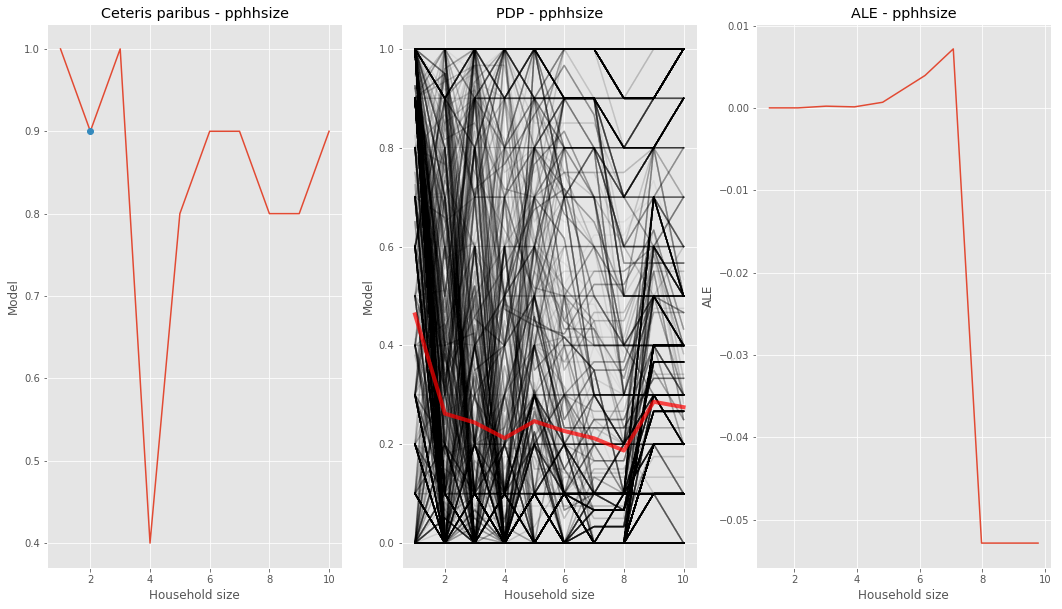

In [213]:
chosen_index = 318
x, y, x_point, y_point = ceteris_paribus(data, model, 'pphhsize', chosen_index)
plt.subplot(1,3,1)
plt.title('Ceteris paribus - pphhsize')
plt.plot(x, y)
plt.plot(x_point, y_point, 'o')
plt.xlabel('Household size')
plt.ylabel('Model')
plt.subplot(1,3,2)
pdp_plot(data, model, 'pphhsize')
plt.title('PDP - pphhsize')
plt.xlabel('Household size')
plt.ylabel('Model')
x, y = ale_func(data, model, 'pphhsize', bins=20)
plt.subplot(1,3,3)
plt.title('ALE - pphhsize')
plt.plot(x, y)
plt.xlabel('Household size')
plt.ylabel('ALE')
plt.show()

##### W przypadku wielkości domu dla poszczególnych przypadków Cerebis paribus pokazuje zmiany w predykcji, natomiast ALE jest stale bliskie 0, a PDP pokazuje duże rożnice między poszczególnymi przypadkami - zmienna nie polepsza predykcji. 


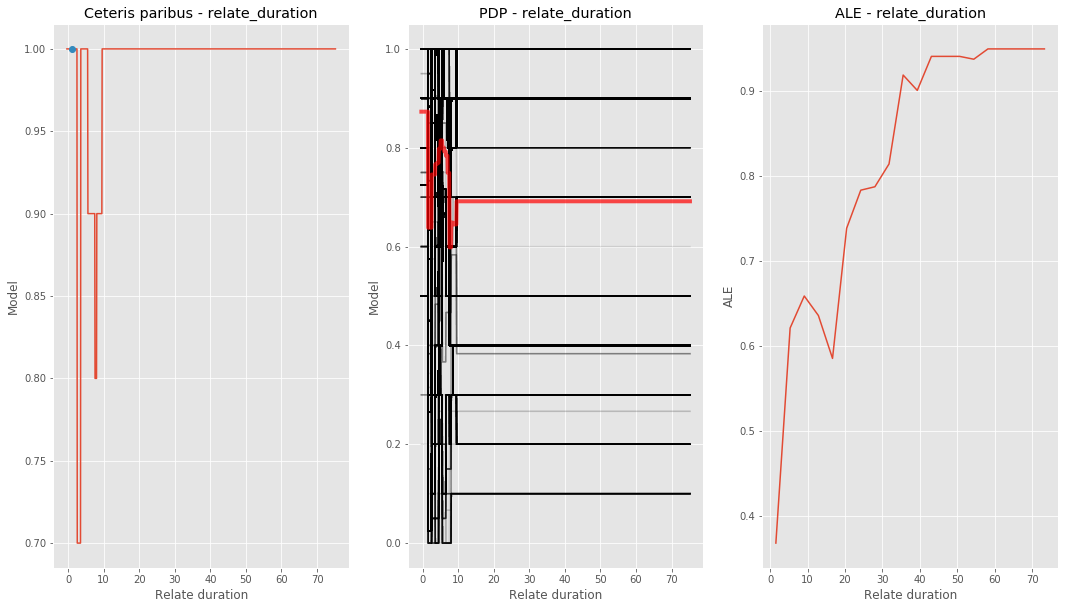

In [214]:
plt.figure()
x, y, x_point, y_point = ceteris_paribus(data, model, 'relate_duration', chosen_index)
plt.subplot(1,3,1)
plt.title('Ceteris paribus - relate_duration')
plt.plot(x, y)
plt.plot(x_point, y_point[0], 'o')
plt.xlabel('Relate duration')
plt.ylabel('Model')
plt.subplot(1,3,2)
pdp_plot(data, model, 'relate_duration')
plt.title('PDP - relate_duration')
plt.xlabel('Relate duration')
plt.ylabel('Model')
x, y = ale_func(data, model, 'relate_duration', bins=20)
plt.subplot(1,3,3)
plt.title('ALE - relate_duration')
plt.plot(x, y)
plt.xlabel('Relate duration')
plt.ylabel('ALE')
plt.show()

##### Przykładowy profil Ceteris paribus pokazuje skorelowanie długości zwiażku z małżenstwem, natomiast PDP ta zależność nie jest tak widoczna jak w ALE.